# Data Pipeline SVM Model
The data pipeline use SVM model to predict hyperbolas in GPR images.  
The final model of SVM uses the following features:
- LBP histogram 128 bins
- HOG histogram 128 bins

## Output
The output of the data pipeline is a image with the output of the model.  
The output files include:
- `output_SVM.jpg`: The GPR image same as the input image, but with the label generated by the model.

In [1]:
import copy
import cv2
import joblib
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
#lbp
import cv2
from skimage.feature import local_binary_pattern
def lbp_histogram(image, radius, bins):
    # compute the LBP histogram of the image
    n_points = 8 * radius
    lbp = local_binary_pattern(image, n_points, radius, method='uniform')
    hist, _ = np.histogram(lbp, bins= bins, range= (0,255), density=False)
    return np.ravel(hist)

def norm(feature): #normalization of single feature bins
    norm = np.linalg.norm(feature[:len(feature)])
    for i in range(len(feature)):
        feature[i] = feature[i] / norm
    return feature

# HoG
from skimage.feature import hog
def hog_(image, orientations, image_size, pixels_per_cell):
#     gray_img = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
    fd, hog_image = hog(image, orientations= orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                	cells_per_block=(2, 2), visualize=True, feature_vector = True)
    return fd

In [3]:
# calculate the voting result based on the index of the sliding window
def label_voting(validate_result, threshold, image_shape, sliding_window_size, step, image_start):
    height = math.ceil((image_shape[0] - sliding_window_size - image_start[0]) / step)
    width = math.ceil((image_shape[1] - sliding_window_size - image_start[1]) / step)
    voting = np.zeros((height + 4, width + 4))
    total = np.zeros((height + 4, width + 4))

    for j in range(height):
        for i in range(width):
            p = validate_result[i + j * width, 1]
            voting[j : j + 5, i : i + 5] += np.ones((5, 5)) * p
            total[j : j + 5, i : i + 5] += np.ones((5, 5))
    voting /= total
    voting = np.where(voting > threshold, 1, 0)

    labeled = []
    for j in range(height + 4):
        for i in range(width + 4):
            sliding_window = [image_start[1] + i * step, image_start[0] + j * step, image_start[1] + (i + 1) * step, image_start[0] + (j + 1) * step]
            if voting[j, i] == 1:
                labeled.append(sliding_window)
    return labeled

In [4]:
def save_labeled_image(image, boxes, file_name='output.jpg'):
    img = copy.deepcopy(image)
    color = np.array([3, 67, 223])
    box_width = 2
    for box in boxes:
        img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :] = np.ones_like(img[box[1] - box_width:box[1] + box_width, box[0]:box[2], :]) * color
        img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :] = np.ones_like(img[box[3] - box_width:box[3] + box_width, box[0]:box[2], :]) * color
        img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :] = np.ones_like(img[box[1]:box[3], box[0] - box_width:box[0] + box_width, :]) * color
        img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :] = np.ones_like(img[box[1]:box[3], box[2] - box_width:box[2] + box_width, :]) * color
    plt.imshow(img)
    plt.imsave(file_name, img)

## Parameters Setting
The parameters of the validation are:
- `IMAGE_START`, `AXIS_ZERO`:　The start position of the image containing signal from the surface.
- `model_name`: The name of the model.
- `image_name`: The name of the GPR image.
- `scale_percent`: The resize ratio of the image.

In [5]:
# IMAGE_START excludes the left axis of the image.
# AXIS_ZERO excludes the top axis of the image. For 1st dataset and 2nd dataset, this also excludes
# the first few nano seconds of the image that receive no signal from the surface.

# Boundary constant of images
IMAGE_START = 64
AXIS_ZERO = 44     # 1st dataset, 2nd dataset: 121, 3rd dataset: 44

model_name = "saved_models/svm_model_1n2dataset_probability.joblib"
model = joblib.load(model_name)
image_name = "ARR7_350_230324__001 P_31111111.JPG"
image_path = f"../data_preprocessing/unprocessed_images/{image_name}"

sliding_window_size = 200
step = 40
img = cv2.imread(image_path)

# scale down
scale_percent = 75 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
IMAGE_START = int(IMAGE_START * scale_percent / 100)
AXIS_ZERO = int(AXIS_ZERO * scale_percent / 100)
image_start = [AXIS_ZERO, IMAGE_START]

height = math.ceil((img.shape[0] - sliding_window_size - image_start[0]) / step)
width = math.ceil((img.shape[1] - sliding_window_size - image_start[1]) / step)
number_image = height * width

In [6]:
# Calculate the Features
count = 0

# LBP histogram features
radius = 1 # radius of local binary pattern histogram
bins = 128 # max = 256 
lbp = np.zeros(shape=(number_image, bins))

# HoG histogram features
hog_array = np.zeros(shape=(number_image, 128))

for j in range(height):
    for i in range(width):
        sliding_window = [image_start[0] + j * step, image_start[1] + i * step, image_start[0] + sliding_window_size + j * step, image_start[1] + sliding_window_size + i * step]
        sub_img = img[sliding_window[0]:sliding_window[2], sliding_window[1]:sliding_window[3]]
        rgb_weights = [0.2989, 0.5870, 0.1140]
        sub_img = np.dot(sub_img[...,:3], rgb_weights)
        sub_img = np.array(sub_img).astype(np.uint8)

        # add lbp to features
        lbp[count] = lbp_histogram(sub_img, radius, bins)
        
        # add hog to features
        hog_array[count] = hog_(sub_img, 8, 200, 60)
        
        count += 1

# Combine Hog and LBP to features array (training data)
features = lbp.copy()

# normalize lbp
for i in range(number_image):
    features[i] = norm(features[i])
    
features = np.insert(features, 128, np.transpose(hog_array), axis=1)
print(features.shape)

(6391, 256)


In [7]:
validate_result = model.predict_proba(features)

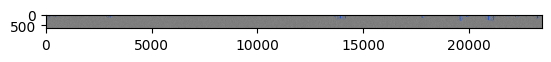

In [8]:
labeled = label_voting(validate_result, 0.1, img.shape, sliding_window_size, step, [AXIS_ZERO, IMAGE_START])
save_labeled_image(img, labeled, file_name='output_SVM.jpg')